### DATA PREPROCESSING

Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from glob import glob
import zipfile
from tqdm import tqdm
import cv2
from tensorflow.keras.utils import Sequence

In [19]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


Loading Data

In [ ]:
zip_path = '/content/crowd_wala_dataset.zip'
extract_to = '/content'

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to: {extract_to}")

Files extracted to: /content


converting .mat files to density maps

In [6]:
def gaussian_kernel_discrete(sigma=15):
    kernel_radius = int(2.5 * sigma)
    size = 2 * kernel_radius + 1
    ax = np.arange(-kernel_radius, kernel_radius + 1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel /= np.sum(kernel)
    return kernel

def generate_density_map(image_shape, points, sigma=15):
    h, w = image_shape
    density_map = np.zeros((h, w), dtype=np.float32)
    kernel = gaussian_kernel_discrete(sigma)
    kH, kW = kernel.shape
    kH2, kW2 = kH // 2, kW // 2

    for point in points:
        x = min(w - 1, max(0, int(point[0])))
        y = min(h - 1, max(0, int(point[1])))

        x1 = max(0, x - kW2)
        x2 = min(w, x + kW2 + 1)
        y1 = max(0, y - kH2)
        y2 = min(h, y + kH2 + 1)

        kx1 = kW2 - (x - x1)
        kx2 = kW2 + (x2 - x)
        ky1 = kH2 - (y - y1)
        ky2 = kH2 + (y2 - y)

        density_map[y1:y2, x1:x2] += kernel[ky1:ky2, kx1:kx2]

    return density_map

def load_points_from_mat(mat_file):
    mat = sio.loadmat(mat_file)
    try:
        points = mat['image_info'][0, 0][0, 0][0]
    except:
        raise ValueError("Check the internal structure of your .mat file.")
    return points

Example results for density maps

Image: IMG_1.jpg
→ Number of people (points): 234
→ Sum of density map: 210.57



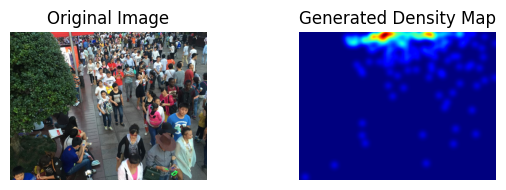

Image: IMG_10.jpg
→ Number of people (points): 230
→ Sum of density map: 207.34



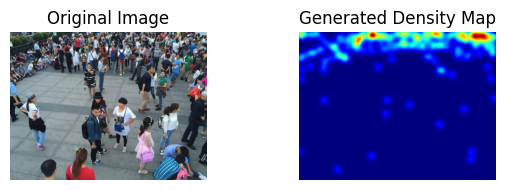

Image: IMG_100.jpg
→ Number of people (points): 206
→ Sum of density map: 203.86



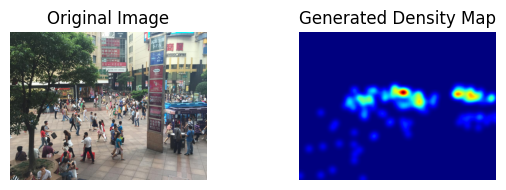

Image: IMG_101.jpg
→ Number of people (points): 83
→ Sum of density map: 80.14



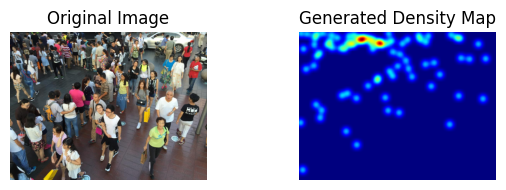

In [ ]:
image_dir = '/content/crowd_wala_dataset/train_data/images'
mat_dir = '/content/crowd_wala_dataset/train_data/ground_truth'

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])[:4]

for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    mat_path = os.path.join(mat_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_shape = img.shape[:2]  # (height, width)

    points = load_points_from_mat(mat_path)
    density_map = generate_density_map(img_shape, points, sigma=15)

    print(f"Image: {img_file}")
    print(f"→ Number of people (points): {len(points)}")
    print(f"→ Sum of density map: {density_map.sum():.2f}\n")

    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(density_map, cmap='jet')
    plt.title('Generated Density Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Files extracted to: /content
Image: IMG_1.jpg
→ Image shape: (768, 1024)
→ Number of people (points): 234
→ Sum of density map: 210.57
→ Max density value: 0.0091
→ Density map shape: (768, 1024)



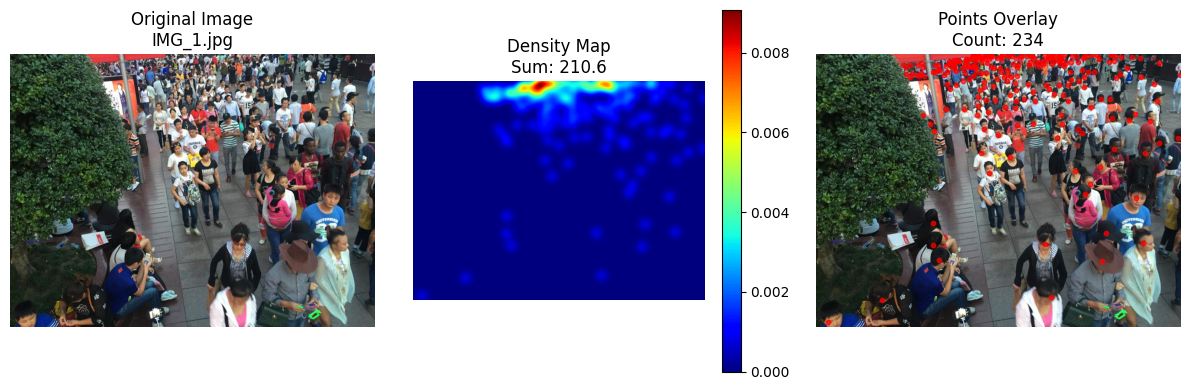

Image: IMG_10.jpg
→ Image shape: (768, 1024)
→ Number of people (points): 230
→ Sum of density map: 207.34
→ Max density value: 0.0052
→ Density map shape: (768, 1024)



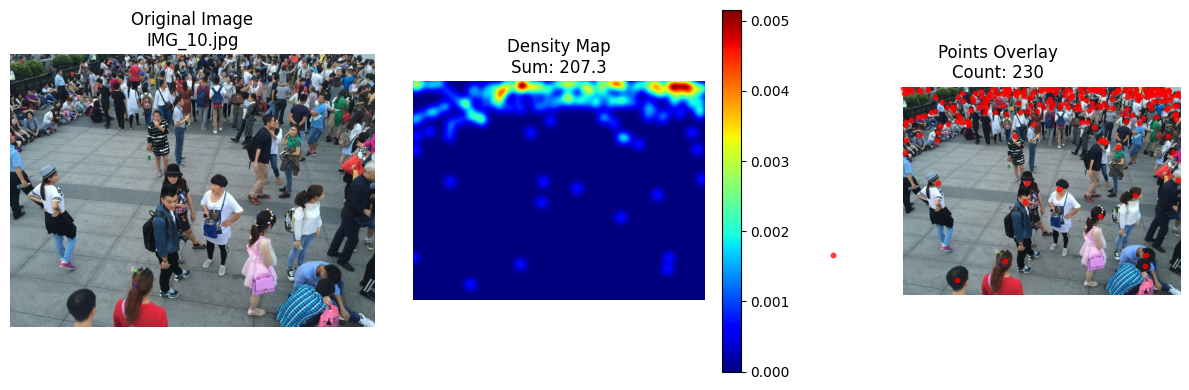

Image: IMG_100.jpg
→ Image shape: (768, 1024)
→ Number of people (points): 206
→ Sum of density map: 203.86
→ Max density value: 0.0078
→ Density map shape: (768, 1024)



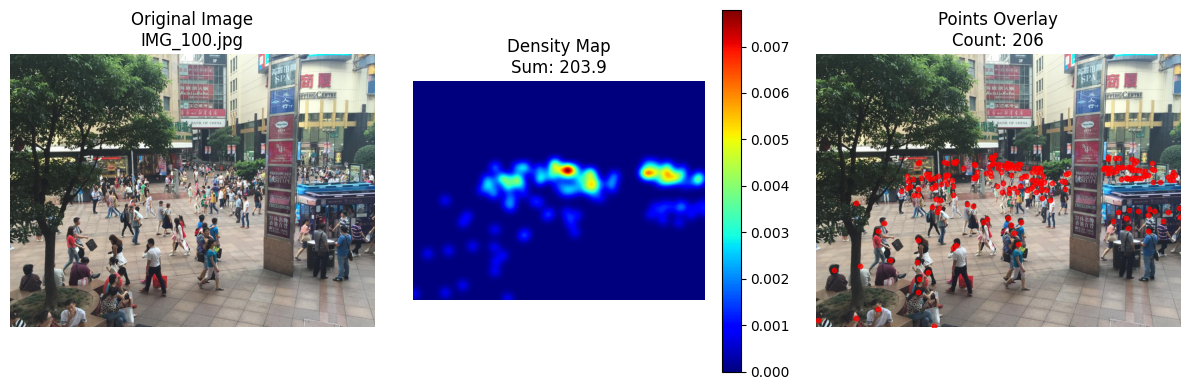

Image: IMG_101.jpg
→ Image shape: (768, 1024)
→ Number of people (points): 83
→ Sum of density map: 80.14
→ Max density value: 0.0024
→ Density map shape: (768, 1024)



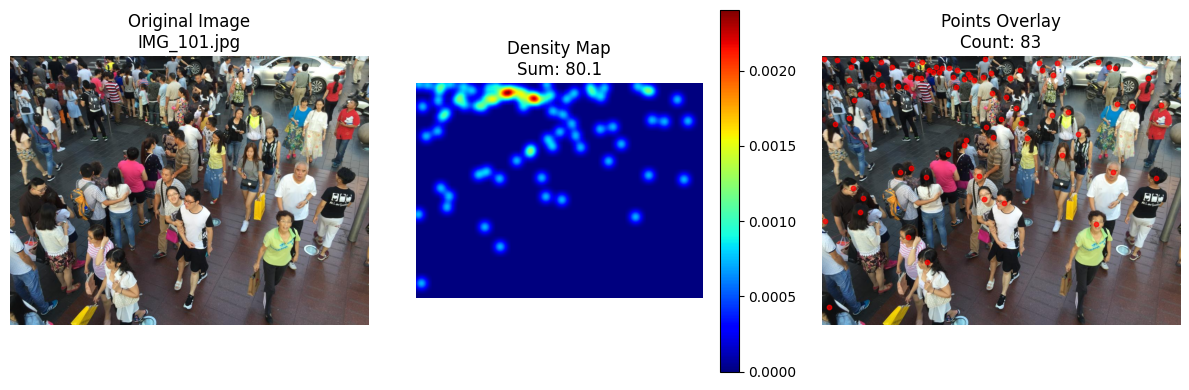

In [ ]:
import os
import zipfile
import numpy as np
import cv2
import scipy.io as sio
import matplotlib.pyplot as plt

def extract_dataset(zip_path, extract_to='/content'):
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Zip file not found: {zip_path}")

    os.makedirs(extract_to, exist_ok=True)

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Files extracted to: {extract_to}")
    except zipfile.BadZipFile:
        raise ValueError(f"Invalid zip file: {zip_path}")

def gaussian_kernel_discrete(sigma=15):
    kernel_radius = int(2.5 * sigma)
    size = 2 * kernel_radius + 1
    ax = np.arange(-kernel_radius, kernel_radius + 1, dtype=np.float32)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel /= np.sum(kernel)  # Normalize to ensure sum = 1
    return kernel

def generate_density_map(image_shape, points, sigma=15):
    h, w = image_shape
    density_map = np.zeros((h, w), dtype=np.float32)

    if len(points) == 0:
        return density_map

    kernel = gaussian_kernel_discrete(sigma)
    kH, kW = kernel.shape
    kH2, kW2 = kH // 2, kW // 2

    for point in points:
        x = int(np.clip(point[0], 0, w - 1))
        y = int(np.clip(point[1], 0, h - 1))

        x1 = max(0, x - kW2)
        x2 = min(w, x + kW2 + 1)
        y1 = max(0, y - kH2)
        y2 = min(h, y + kH2 + 1)

        kx1 = kW2 - (x - x1)
        kx2 = kW2 + (x2 - x)
        ky1 = kH2 - (y - y1)
        ky2 = kH2 + (y2 - y)

        density_map[y1:y2, x1:x2] += kernel[ky1:ky2, kx1:kx2]

    return density_map

def load_points_from_mat(mat_file):
    if not os.path.exists(mat_file):
        raise FileNotFoundError(f"Mat file not found: {mat_file}")

    try:
        mat = sio.loadmat(mat_file)

        possible_keys = ['image_info', 'annPoints', 'points', 'locations']

        for key in possible_keys:
            if key in mat:
                if key == 'image_info':
                    try:
                        points = mat[key][0, 0][0, 0][0]
                        break
                    except:
                        continue
                else:
                    points = mat[key]
                    break
        else:
            print(f"Available keys in {mat_file}: {list(mat.keys())}")
            raise KeyError("Could not find annotation points in mat file")

        points = np.array(points)
        if points.ndim == 1 and len(points) == 0:
            return np.empty((0, 2))
        elif points.ndim == 1:
            points = points.reshape(-1, 2)

        return points

    except Exception as e:
        print(f"Error loading {mat_file}: {str(e)}")
        raise

def visualize_density_analysis(image_dir, mat_dir, num_images=4):

    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Image directory not found: {image_dir}")
    if not os.path.exists(mat_dir):
        raise FileNotFoundError(f"Mat directory not found: {mat_dir}")

    image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    if len(image_files) == 0:
        raise ValueError("No image files found in the directory")

    # Limit number of images to process
    image_files = image_files[:num_images]

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        base_name = os.path.splitext(img_file)[0]
        possible_mat_names = [
            f'GT_{base_name}.mat',
            f'{base_name}_ann.mat',
            f'{base_name}.mat'
        ]

        mat_path = None
        for mat_name in possible_mat_names:
            potential_path = os.path.join(mat_dir, mat_name)
            if os.path.exists(potential_path):
                mat_path = potential_path
                break

        if mat_path is None:
            print(f"⚠️ No corresponding mat file found for {img_file}")
            continue

        try:
            # Load and process image
            img = cv2.imread(img_path)
            if img is None:
                print(f"⚠️ Could not load image: {img_file}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_shape = img.shape[:2]  # (height, width)

            points = load_points_from_mat(mat_path)
            density_map = generate_density_map(img_shape, points, sigma=15)

            print(f"Image: {img_file}")
            print(f"→ Image shape: {img_shape}")
            print(f"→ Number of people (points): {len(points)}")
            print(f"→ Sum of density map: {density_map.sum():.2f}")
            print(f"→ Max density value: {density_map.max():.4f}")
            print(f"→ Density map shape: {density_map.shape}\n")

            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title(f'Original Image\n{img_file}')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(density_map, cmap='jet')
            plt.title(f'Density Map\nSum: {density_map.sum():.1f}')
            plt.colorbar()
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(img)
            if len(points) > 0:
                plt.scatter(points[:, 0], points[:, 1], c='red', s=10, alpha=0.7)
            plt.title(f'Points Overlay\nCount: {len(points)}')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error processing {img_file}: {str(e)}")
            continue
if __name__ == "__main__":
    zip_path = '/content/crowd_wala_dataset.zip'
    extract_to = '/content'
    try:
        extract_dataset(zip_path, extract_to)
    except Exception as e:
        print(f"Extraction failed: {str(e)}")
        exit(1)

    image_dir = '/content/crowd_wala_dataset/train_data/images'
    mat_dir = '/content/crowd_wala_dataset/train_data/ground_truth'

    try:
        visualize_density_analysis(image_dir, mat_dir, num_images=4)
    except Exception as e:
        print(f"Analysis failed: {str(e)}")

saving all density maps in one folder  "ground_truth_density_map"

In [ ]:

input_dir = '/content/crowd_wala_dataset/train_data/ground_truth'
output_dir = '/content/crowd_wala_dataset/train_data/ground_truth_density_map'
os.makedirs(output_dir, exist_ok=True)

image_shape = (768, 1024)

mat_files = [f for f in os.listdir(input_dir) if f.endswith('.mat')]

for file in tqdm(mat_files, desc="Generating density maps"):
    mat_path = os.path.join(input_dir, file)
    points = load_points_from_mat(mat_path)
    density_map = generate_density_map(image_shape, points, sigma=15)

    output_path = os.path.join(output_dir, file.replace('.mat', '.npy'))
    np.save(output_path, density_map)

Generating density maps: 100%|██████████| 400/400 [00:07<00:00, 52.14it/s] 


Making dataset for training

In [ ]:
class ImageDensityMapGenerator(Sequence):
    def __init__(self, image_dir, density_dir, image_size=(224, 224), batch_size=16, shuffle=True):
        self.image_dir = image_dir
        self.density_dir = density_dir
        self.image_size = (1024, 768)
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Get sorted image filenames
        self.image_filenames = sorted([
            fname for fname in os.listdir(image_dir) if fname.endswith('.jpg')
        ])
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

    def __getitem__(self, index):
        batch_filenames = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_density_maps = []

        for fname in batch_filenames:
            img_path = os.path.join(self.image_dir, fname)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.image_size)
            img = img.astype(np.float32)

            density_fname = 'GT_' + fname.replace('.jpg', '.npy')
            density_path = os.path.join(self.density_dir, density_fname)
            density_map = np.load(density_path)

            original_sum = density_map.sum()
            density_map = cv2.resize(density_map, (1024, 768), interpolation=cv2.INTER_CUBIC)
            density_map *= (original_sum / density_map.sum() + 1e-6)
            density_map = density_map[..., np.newaxis]

            batch_images.append(img)
            batch_density_maps.append(density_map)

        return np.array(batch_images), np.array(batch_density_maps)

making training and validation sets

In [ ]:

train_gen = ImageDensityMapGenerator(
    image_dir='/content/crowd_wala_dataset/train_data/images',
    density_dir='/content/crowd_wala_dataset/train_data/ground_truth_density_map',
    image_size=(224, 224),
    batch_size=16,
    shuffle=True)
total_size = len(train_gen.image_filenames)
train_size = int(0.9 * total_size)
val_filenames = train_gen.image_filenames[train_size:]
train_filenames = train_gen.image_filenames[:train_size]

train_gen.image_filenames = train_filenames
val_gen = ImageDensityMapGenerator(
    image_dir=train_gen.image_dir,
    density_dir=train_gen.density_dir,
    image_size=train_gen.image_size,
    batch_size=train_gen.batch_size,
    shuffle=False)

val_gen.image_filenames = val_filenames

visualizing training set

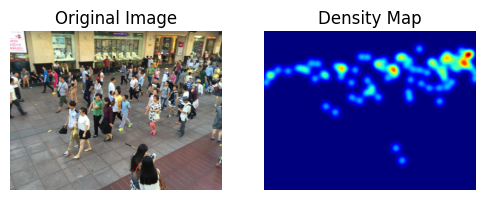

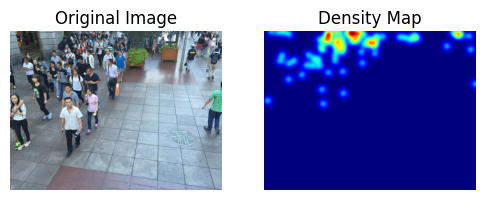

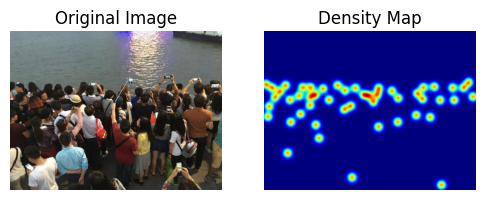

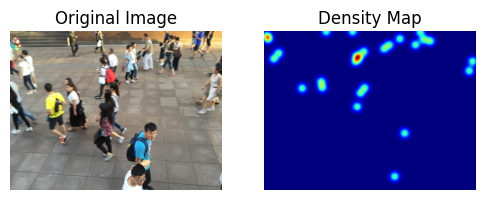

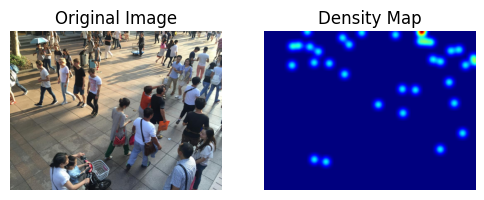

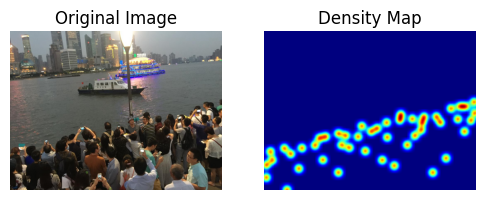

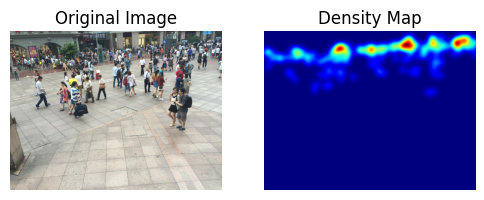

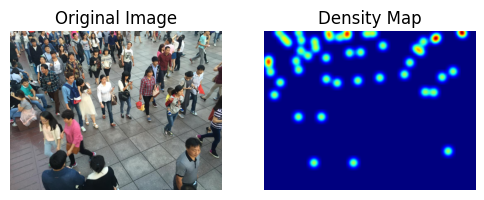

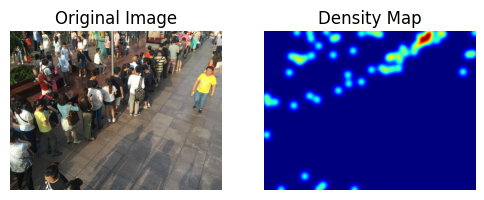

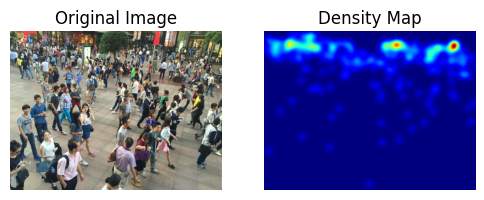

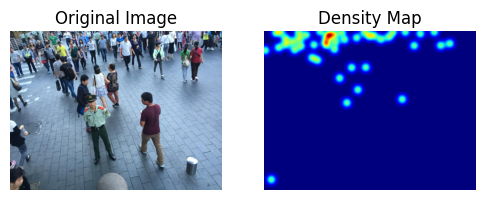

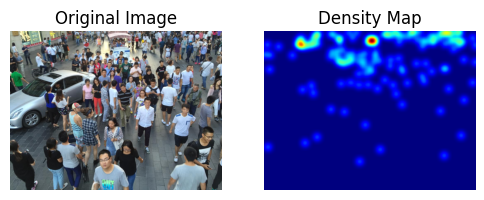

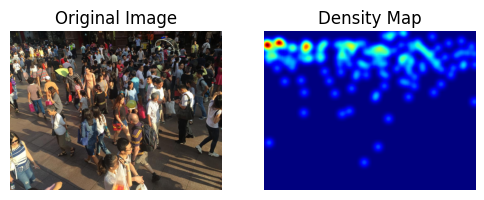

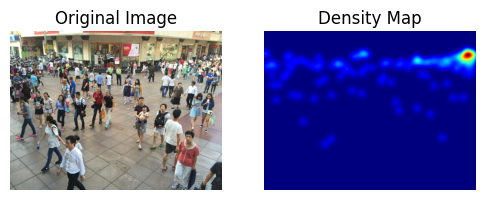

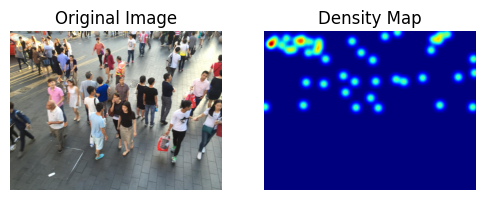

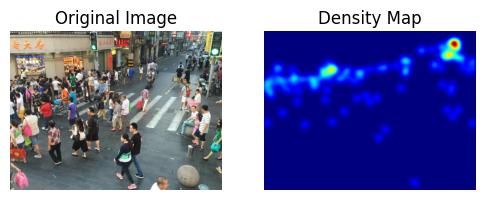

In [ ]:
import matplotlib.pyplot as plt

images, density_maps = train_gen[0]
for i in range(len(images)):
    plt.figure(figsize=(6, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(images[i].astype('uint8'))
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(density_maps[i].squeeze(), cmap='jet')
    plt.title('Density Map')
    plt.axis('off')

    plt.show()

### MODEL TRAINING

defining loss function

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import Sequence
import os

def gaussian_kernel(size: int, sigma: float):
    coords = tf.range(size, dtype=tf.float32) - size // 2
    g = tf.exp(-(coords ** 2) / (2. * sigma ** 2))
    g = g / tf.reduce_sum(g)
    return tf.tensordot(g, g, axes=0)

def ssim_loss(y_true, y_pred, window_size=11, C1=0.01**2, C2=0.03**2):
    kernel = gaussian_kernel(window_size, 1.5)
    kernel = kernel[:, :, tf.newaxis, tf.newaxis]

    mu1 = tf.nn.conv2d(y_true, kernel, strides=[1, 1, 1, 1], padding='SAME')
    mu2 = tf.nn.conv2d(y_pred, kernel, strides=[1, 1, 1, 1], padding='SAME')

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = tf.nn.conv2d(y_true ** 2, kernel, strides=[1, 1, 1, 1], padding='SAME') - mu1_sq
    sigma2_sq = tf.nn.conv2d(y_pred ** 2, kernel, strides=[1, 1, 1, 1], padding='SAME') - mu2_sq
    sigma12 = tf.nn.conv2d(y_true * y_pred, kernel, strides=[1, 1, 1, 1], padding='SAME') - mu1_mu2

    ssim_map = ((2. * mu1_mu2 + C1) * (2. * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return 1 - tf.reduce_mean(ssim_map)

def mssim_loss(y_true, y_pred):
    levels = 5
    weights = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]
    mssim = 0.0

    for i in range(levels):
        mssim += weights[i] * (1 - ssim_loss(y_true, y_pred))
        if i < levels - 1:
            y_true = tf.nn.avg_pool2d(y_true, ksize=2, strides=2, padding='SAME')
            y_pred = tf.nn.avg_pool2d(y_pred, ksize=2, strides=2, padding='SAME')

    return 1.0 - mssim

def mae_metric(y_true, y_pred):
    true_count = tf.reduce_sum(y_true, axis=[1, 2, 3])
    pred_count = tf.reduce_sum(y_pred, axis=[1, 2, 3])
    return tf.reduce_mean(tf.abs(true_count - pred_count))


model architecture

In [23]:
def build_model(input_shape=(224, 224, 3)):
    base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    backbone = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('block4_conv3').output)

    x = backbone.output
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)

    attention = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    attention = layers.Conv2D(1, 1, activation='sigmoid')(attention)
    attended = layers.Multiply()([x, attention])

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(attended)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
    output = layers.Conv2D(1, 1, activation='relu')(x)

    model = tf.keras.Model(inputs=backbone.input, outputs=output)
    return model

training model

In [ ]:
model = build_model()
model.compile(
    optimizer='adam',
    loss=mssim_loss,
    metrics=[mae_metric]
)

checkpoint = ModelCheckpoint(
    'best_model_mssim.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint],
    verbose=1
)

# Print Final Validation MAE
final_val_mae = history.history['val_mae_metric'][-1]
print(f"\nFinal Validation MAE: {final_val_mae:.4f}")


Epoch 1/50


ValueError: Input 0 of layer "functional_12" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 384, 512, 3)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import os
import cv2
def mae_metric(y_true, y_pred):
    true_count = tf.reduce_sum(y_true, axis=[1, 2, 3])
    pred_count = tf.reduce_sum(y_pred, axis=[1, 2, 3])
    return tf.reduce_mean(tf.abs(true_count - pred_count))
class ImageDensityMapGenerator(Sequence):
    def __init__(self, image_dir, density_dir, image_size=(768, 1024), batch_size=8, shuffle=True):
        self.image_dir = image_dir
        self.density_dir = density_dir
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_filenames) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

    def __getitem__(self, index):
        batch_filenames = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_density_maps = []

        for fname in batch_filenames:
            img = cv2.imread(os.path.join(self.image_dir, fname))
            img = cv2.resize(img, (self.image_size[1], self.image_size[0]))
            img = img.astype(np.float32)

            dmap_path = os.path.join(self.density_dir, 'GT_' + fname.replace('.jpg', '.npy'))
            dmap = np.load(dmap_path)
            original_count = np.sum(dmap)
            dmap = cv2.resize(dmap, (self.image_size[1], self.image_size[0]), interpolation=cv2.INTER_CUBIC)
            if dmap.sum() > 0:
                dmap *= (original_count / dmap.sum())
            dmap = dmap[..., np.newaxis]

            batch_images.append(img)
            batch_density_maps.append(dmap)

        return np.array(batch_images), np.array(batch_density_maps)
def build_model(input_shape=(768, 1024, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    output = layers.Conv2D(1, 1, padding='same', activation='relu')(x)
    return models.Model(inputs=inputs, outputs=output)
train_gen = ImageDensityMapGenerator(
    image_dir='/content/crowd_wala_dataset/train_data/images',
    density_dir='/content/crowd_wala_dataset/train_data/ground_truth_density_map',
    image_size=(384, 512),  # reduced from (768, 1024)
    batch_size=4,           # reduced from 8
    shuffle=True
)

val_gen = ImageDensityMapGenerator(
    image_dir='/content/crowd_wala_dataset/train_data/images',
    density_dir='/content/crowd_wala_dataset/train_data/ground_truth_density_map',
    image_size=(384, 512),
    batch_size=4,
    shuffle=False
)
val_gen.image_filenames = train_gen.image_filenames[int(0.9 * len(train_gen.image_filenames)):]
train_gen.image_filenames = train_gen.image_filenames[:int(0.9 * len(train_gen.image_filenames))]

model = build_model(input_shape=(384, 512, 3))
model.compile(
    optimizer='adam',
    loss=mssim_loss,
    metrics=[mae_metric]
)

checkpoint = ModelCheckpoint(
    'best_model_mssim.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[checkpoint],
    verbose=1
)

# Print Final Validation MAE
final_val_mae = history.history['val_mae_metric'][-1]
print(f"\nFinal Validation MAE: {final_val_mae:.4f}")



Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - loss: 0.0717 - mae_metric: 1755.1965
Epoch 1: val_loss improved from inf to 0.01950, saving model to best_model_mssim.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - loss: 0.0712 - mae_metric: 1740.7164 - val_loss: 0.0195 - val_mae_metric: 127.3479
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0158 - mae_metric: 110.3037
Epoch 2: val_loss did not improve from 0.01950
90/90 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - loss: 0.0158 - mae_metric: 110.3582 - val_loss: 0.0195 - val_mae_metric: 127.3479
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0148 - mae_metric: 105.1197
Epoch 3: val_loss did not improve from 0.01950
90/90 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - loss: 0.0148 - mae_metric: 105.2312 - val_loss: 0.0195 - val_mae_metric: 127.3479
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0163 - mae_metric: 113.1791
Epoch 4: val_loss did not improve from 0.01950
90/90 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - loss: 0.0163 - mae_metric: 113.2020 - val_loss: 0.0195 - val_mae_metric: 127.3479
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0164 - mae_metric: 114.8343
Epoch 5: val_loss di

Plotting loss function

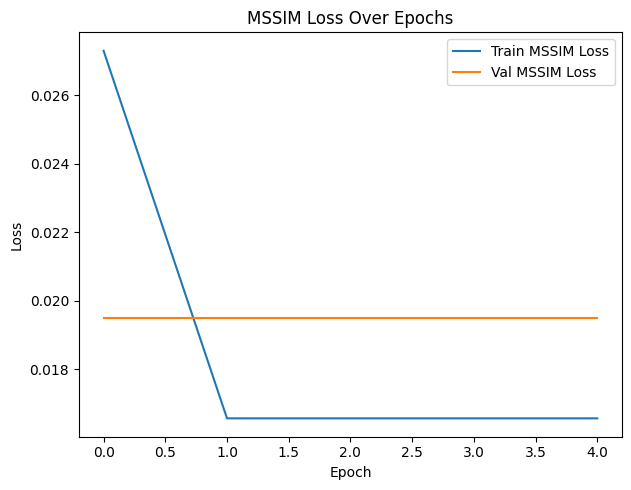

In [26]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train MSSIM Loss')
plt.plot(history.history['val_loss'], label='Val MSSIM Loss')
plt.title('MSSIM Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()